In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np
import celltypist
from celltypist import models
from scipy.sparse import csc_matrix
import os

In [3]:
atlas = sc.read_h5ad('/nfs/data/omnideconv_benchmarking_clean/scdownstream_results/finalized/merged.h5ad')
atlas

AnnData object with n_obs × n_vars = 451932 × 52428
    obs: 'label', 'cell_type', 'total_counts_ribo', 'cell_type_broad', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset_id_custom', 'label:scANVI', 'scvi-global-1_leiden', 'scvi-global-0.5_leiden', 'scvi-global-4_leiden', 'scvi-global-5_leiden', 'scvi-global-2_leiden', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-global-2_characteristic_genes', 'scanvi-global-2_pa

In [3]:
cellxgene_annotations = pd.read_csv('/nfs/data/omnideconv_benchmarking_clean/scdownstream_results/finalized/cellxgene_annotations.csv', header=2)
cellxgene_annotations

,index,cell_type_lorenzo,annotation_final
0,TabulaSapiens_295930,NaN,unassigned
1,TabulaSapiens_295931,NaN,unassigned
2,TabulaSapiens_295932,NaN,unassigned
3,TabulaSapiens_295933,NaN,Plasma cells
4,TabulaSapiens_295934,NaN,Plasma cells
...,...,...,...
451927,Hao_E2L8_TTTGTTGGTCGTGATT,NaN,CD8 T cells
451928,Hao_E2L8_TTTGTTGGTGTGCCTG,NaN,Monocytes
451929,Hao_E2L8_TTTGTTGGTTAGTTCG,NaN,memory B cells
451930,Hao_E2L8_TTTGTTGGTTGGCTAT,NaN,Macrophages


In [4]:
atlas.obs = atlas.obs.merge(cellxgene_annotations, left_index=True, right_on='index', how='left').copy()
atlas

AnnData object with n_obs × n_vars = 451932 × 52428
    obs: 'label', 'cell_type', 'total_counts_ribo', 'cell_type_broad', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset_id_custom', 'label:scANVI', 'scvi-global-1_leiden', 'scvi-global-0.5_leiden', 'scvi-global-4_leiden', 'scvi-global-5_leiden', 'scvi-global-2_leiden', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden', 'index', 'cell_type_lorenzo', 'annotation_final'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-g

In [5]:
# remove cells with label 'unassigned' in obs column 'annotation_final'
atlas_filtered = atlas[atlas.obs['annotation_final'] != 'unassigned'].copy()
atlas_filtered

AnnData object with n_obs × n_vars = 443842 × 52428
    obs: 'label', 'cell_type', 'total_counts_ribo', 'cell_type_broad', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset_id_custom', 'label:scANVI', 'scvi-global-1_leiden', 'scvi-global-0.5_leiden', 'scvi-global-4_leiden', 'scvi-global-5_leiden', 'scvi-global-2_leiden', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden', 'index', 'cell_type_lorenzo', 'annotation_final'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-g

In [6]:
atlas_filtered.obs.rename(columns={
    "annotation_final": "cell_type_manual",
    "cell_type": "cell_type_original",
    "label": "cell_type_coarse",
    "dataset_id_custom": "dataset"
}, inplace=True)

atlas_filtered.obs.drop(columns=["cell_type_broad", "label:scANVI", "scvi-global-1_leiden","scvi-global-0.5_leiden","scvi-global-4_leiden","scvi-global-5_leiden","scvi-global-2_leiden","cell_type_lorenzo","index"], inplace=True)
atlas_filtered.obs

,cell_type_coarse,cell_type_original,total_counts_ribo,n_genes_by_counts,sample_original,total_counts_hb,log1p_n_genes_by_counts,pct_counts_mt,log1p_total_counts_ribo,total_counts_mt,...,sample,n_genes,log1p_total_counts,dataset,scanvi-global-0.5_leiden,scanvi-global-1_leiden,scanvi-global-4_leiden,scanvi-global-5_leiden,scanvi-global-2_leiden,cell_type_manual
3,B_cell,plasma cell,515.0,1791,TSP14,195.0,7.491088,4.637847,6.246107,243.0,...,TabulaSapiens,1791,8.566745,TabulaSapiens,15,27,59,65,37,Plasma cells
4,B_cell,plasma cell,203.0,1500,TSP14,338.0,7.314553,4.153506,5.318120,131.5,...,TabulaSapiens,1500,8.064322,TabulaSapiens,15,27,59,65,37,Plasma cells
5,Rbc,erythrocyte,26.0,798,TSP14,6805.0,6.683361,0.816151,3.295837,66.5,...,TabulaSapiens,798,9.006509,TabulaSapiens,17,28,68,78,40,Erythrocytes
7,B_cell,plasma cell,469.0,1477,TSP14,20.0,7.299121,8.514986,6.152733,312.5,...,TabulaSapiens,1477,8.211211,TabulaSapiens,15,27,59,65,37,Plasma cells
10,B_cell,plasma cell,443.0,1192,TSP14,8.0,7.084226,11.155797,6.095825,319.0,...,TabulaSapiens,1192,7.960324,TabulaSapiens,15,27,59,65,37,Plasma cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451927,T_nk_cell,T cells CD8,3164.0,2196,P5,0.0,7.694848,6.999607,8.059908,534.0,...,Hao,2196,8.939843,Hao,7,10,11,4,9,CD8 T cells
451928,Myeloid_cell,Monocytes,928.0,2936,P5,1.0,7.985144,5.880822,6.834109,452.0,...,Hao,2936,8.947286,Hao,0,4,25,23,4,Monocytes
451929,B_cell,B cells,2323.0,3069,P8,0.0,8.029433,7.007410,7.751045,558.0,...,Hao,3069,8.982687,Hao,5,12,7,16,15,memory B cells
451930,Myeloid_cell,Monocytes,1496.0,3188,P5,1.0,8.067463,5.886774,7.311218,470.0,...,Hao,3188,8.985320,Hao,0,6,15,13,16,Macrophages


In [7]:
cell_type_mapping = {
    "memory B cells": "B cells",
    "naive B cells": "B cells",
    "pDCs": "pDC",
    "mDCs": "mDC",
    "Platelets": "Platelet",
    "ILCs": "ILC",
    "CD4 T cells": "T cells CD4 conv",
    "CD8 T cells": "T cells CD8",
    "Macrophages": "Monocytes"
}
atlas_filtered.obs["cell_type"] = atlas_filtered.obs["cell_type_manual"].replace(cell_type_mapping).astype("category")
#atlas_filtered.obs["cell_type"] = atlas_filtered.obs["cell_type_manual"].astype("category").cat.remove_unused_categories()

atlas_filtered.obs["cell_type"].value_counts()

cell_type
Monocytes           118011
T cells CD4 conv    100553
NK cells             54828
NK T cells           53202
B cells              35135
Neutrophils          28832
T cells CD8          18685
Erythrocytes          9980
mDC                   7888
Tregs                 6556
Platelet              4933
pDC                   3039
Plasma cells          1146
HSCs                   646
ILC                    408
Name: count, dtype: int64

... storing 'cell_type_manual' as categorical


<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

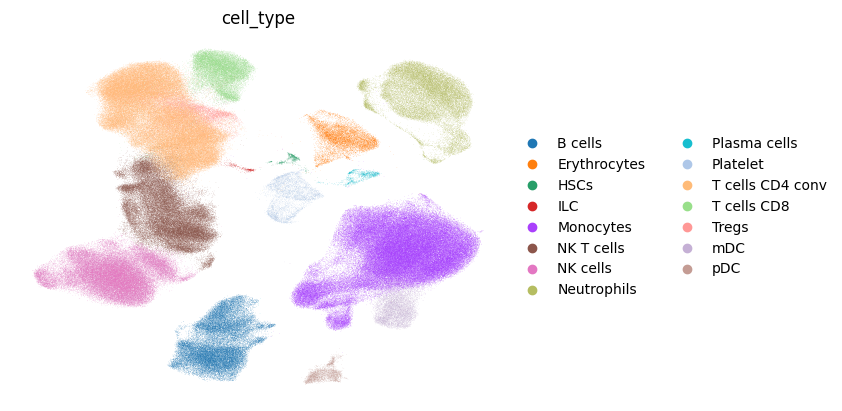

In [8]:
# plot umap
atlas_filtered.obsm['X_umap'] = atlas_filtered.obsm['X_scanvi-global_umap']
sc.pl.umap(atlas_filtered, color='cell_type', frameon=False, show=False)

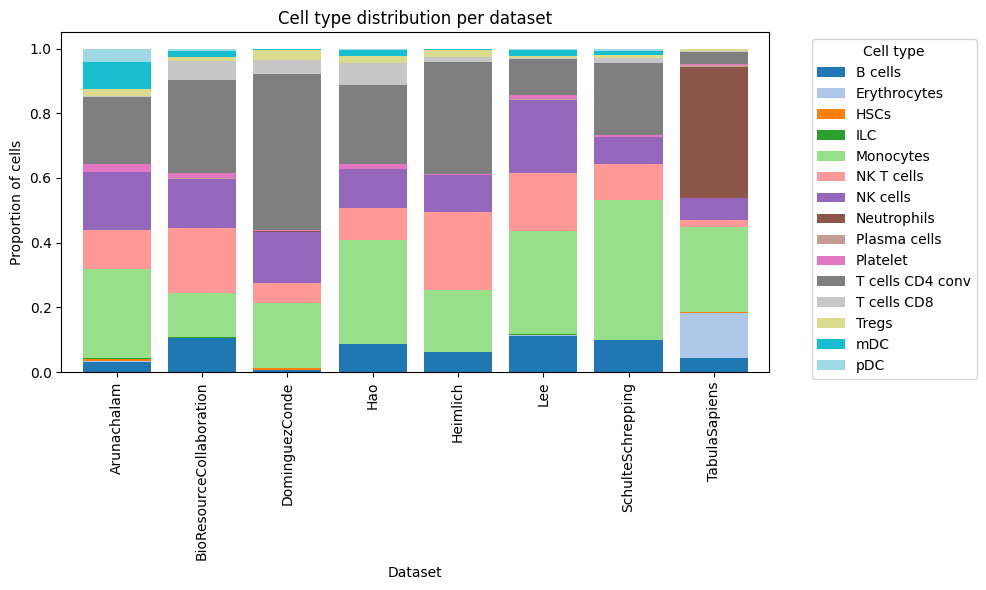

In [9]:
# stacked barplot of celltypes per dataset
cell_counts = pd.crosstab(atlas_filtered.obs['dataset'], atlas_filtered.obs['cell_type'])

cell_props = cell_counts.div(cell_counts.sum(axis=1), axis=0)

ax = cell_props.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, colormap='tab20')

plt.ylabel('Proportion of cells')
plt.xlabel('Dataset')
plt.title('Cell type distribution per dataset')
plt.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
atlas_filtered.write_h5ad('/nfs/data/omnideconv_benchmarking_clean/scdownstream_results/finalized/merged_annotated.h5ad')

In [11]:
base_path = '/nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/'

for dataset_id in atlas_filtered.obs["dataset"].unique():
    # Create a directory for this dataset
    dataset_dir = os.path.join(base_path, dataset_id)
    os.makedirs(dataset_dir, exist_ok=True)

    # Subset the AnnData object
    adata_subset = atlas_filtered[atlas_filtered.obs["dataset"] == dataset_id]

    # create raw and normalized layers
    adata_subset.layers["counts"] = adata_subset.X
    adata_subset.layers["cpm"] = sc.pp.normalize_total(adata_subset, target_sum=1e6, inplace=False)['X']
    
    # Define filename
    filename = os.path.join(dataset_dir, "anndata_annotated.h5ad")
    
    # Save the subset as an .h5ad file
    adata_subset.write_h5ad(filename)

    print(f"Saved {filename}")

Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/TabulaSapiens/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/BioResourceCollaboration/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/DominguezConde/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Arunachalam/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/SchulteSchrepping/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Lee/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Heimlich/anndata_annotated.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Hao/anndata_annotated.h5ad


In [28]:
atlas_filtered2 = atlas_filtered[~atlas_filtered.obs['cell_type'].isin(['unassigned', 'NK T cells','HSCs'])].copy()
atlas_filtered2

AnnData object with n_obs × n_vars = 389994 × 52428
    obs: 'cell_type_coarse', 'cell_type_original', 'total_counts_ribo', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden', 'cell_type_manual', 'cell_type'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-global-2_characteristic_genes', 'scanvi-global-2_paga', 'scanvi-global-4_characteristic_genes', 'scanvi-global-4_paga', 'scanvi-global-5_characteristic_genes', 'scan

In [29]:
# remove cells from celltypes with less than 10 cases in a dataset
group_sizes = atlas_filtered2.obs.groupby(['dataset', 'cell_type']).transform('size')
mask = group_sizes >= 10

atlas_filtered2 = atlas_filtered2[mask].copy()
atlas_filtered2

AnnData object with n_obs × n_vars = 389980 × 52428
    obs: 'cell_type_coarse', 'cell_type_original', 'total_counts_ribo', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden', 'cell_type_manual', 'cell_type'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-global-2_characteristic_genes', 'scanvi-global-2_paga', 'scanvi-global-4_characteristic_genes', 'scanvi-global-4_paga', 'scanvi-global-5_characteristic_genes', 'scan

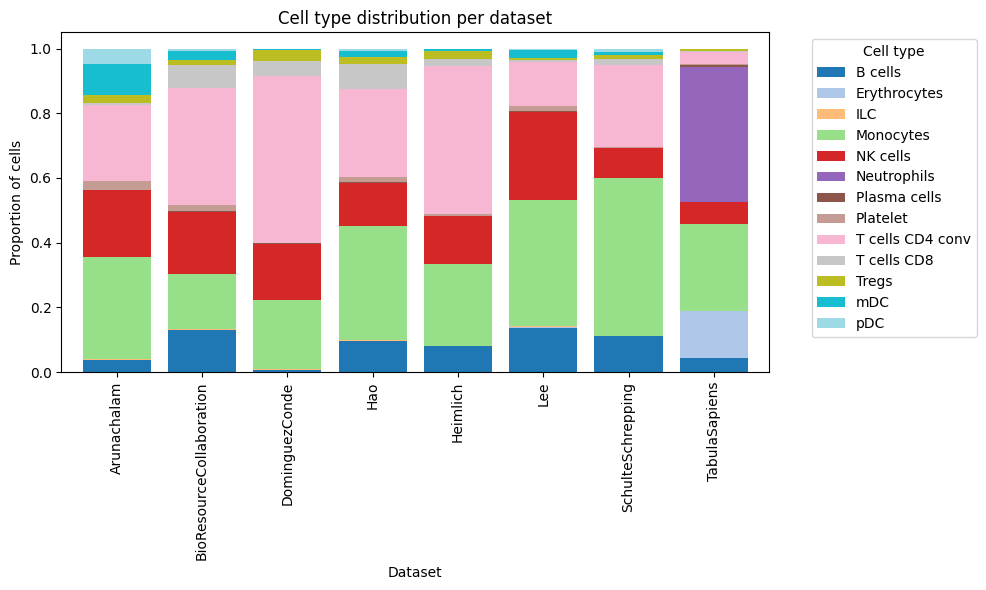

In [30]:
# stacked barplot of celltypes per dataset
cell_counts = pd.crosstab(atlas_filtered2.obs['dataset'], atlas_filtered2.obs['cell_type'])

cell_props = cell_counts.div(cell_counts.sum(axis=1), axis=0)

ax = cell_props.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, colormap='tab20')

plt.ylabel('Proportion of cells')
plt.xlabel('Dataset')
plt.title('Cell type distribution per dataset')
plt.legend(title='Cell type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
cell_counts

cell_type,B cells,Erythrocytes,ILC,Monocytes,NK cells,Neutrophils,Plasma cells,Platelet,T cells CD4 conv,T cells CD8,Tregs,mDC,pDC
dataset,,,,,,,,,,,,,
Arunachalam,802,0,56,6661,4363,0,20,595,4973,131,493,2027,1008
BioResourceCollaboration,10644,0,152,13717,15489,0,161,1512,29265,5770,1258,2077,678
DominguezConde,143,0,10,3800,3013,0,53,14,9086,832,570,62,37
Hao,13378,0,138,48642,18071,0,364,2116,37249,10568,2965,2824,853
Heimlich,1173,0,0,3632,2143,0,0,91,6540,319,384,57,37
Lee,1748,37,15,4962,3481,0,38,195,1723,62,96,299,67
SchulteSchrepping,4119,0,20,17831,3443,0,39,142,9232,639,459,438,344
TabulaSapiens,3128,9936,15,18766,4825,28830,468,268,2485,364,331,104,15


In [32]:
atlas_filtered2.write_h5ad('/nfs/data/omnideconv_benchmarking_clean/scdownstream_results/finalized/merged_annotated_reduced.h5ad')

In [33]:
base_path = '/nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/'

for dataset_id in atlas_filtered2.obs["dataset"].unique():
    # Create a directory for this dataset
    dataset_dir = os.path.join(base_path, dataset_id + '_reduced')
    os.makedirs(dataset_dir, exist_ok=True)

    # Subset the AnnData object
    adata_subset = atlas_filtered2[atlas_filtered2.obs["dataset"] == dataset_id]

    # create raw and normalized layers
    adata_subset.layers["counts"] = adata_subset.X
    adata_subset.layers["cpm"] = sc.pp.normalize_total(adata_subset, target_sum=1e6, inplace=False)['X']
    
    # Define filename
    filename = os.path.join(dataset_dir, "anndata_annotated_filtered.h5ad")
    
    # Save the subset as an .h5ad file
    adata_subset.write_h5ad(filename)

    print(f"Saved {filename}")

Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/TabulaSapiens_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/BioResourceCollaboration_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/DominguezConde_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Arunachalam_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/SchulteSchrepping_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Lee_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Heimlich_reduced/anndata_annotated_filtered.h5ad
Saved /nfs/data/omnideconv_benchmarking_clean/data/singleCellXGeneCensus/Hao_reduced/anndata_annotated_filtered.

In [19]:
atlas_cellxgene = atlas.copy()
integration_methods = ["scvi", "scanvi"]

for integration in integration_methods:
    embedding_key = f"X_{integration}"
    if embedding_key in atlas_cellxgene.obsm.keys():
        atlas_cellxgene.obsm[integration] = atlas_cellxgene.obsm.pop(embedding_key)

for layer in atlas_cellxgene.layers.keys():
    atlas_cellxgene.layers[layer] = csc_matrix(atlas_cellxgene.layers[layer]).astype(np.float32)
atlas_cellxgene.X = csc_matrix(atlas_cellxgene.X).astype(np.float32)
sc.pp.log1p(atlas_cellxgene)
atlas_cellxgene.write_h5ad('/nfs/data/omnideconv_benchmarking_clean/scdownstream_results/finalized/merged_cellxgene_annotated.h5ad')
atlas_cellxgene

AnnData object with n_obs × n_vars = 451932 × 52428
    obs: 'cell_type_coarse', 'cell_type_original', 'total_counts_ribo', 'n_genes_by_counts', 'sample_original', 'total_counts_hb', 'log1p_n_genes_by_counts', 'pct_counts_mt', 'log1p_total_counts_ribo', 'total_counts_mt', 'n_counts', 'batch', 'pct_counts_hb', 'pct_counts_ribo', 'log1p_total_counts_mt', 'cell_type_hao', 'total_counts', 'log1p_total_counts_hb', 'sample', 'n_genes', 'log1p_total_counts', 'dataset', 'scanvi-global-0.5_leiden', 'scanvi-global-1_leiden', 'scanvi-global-4_leiden', 'scanvi-global-5_leiden', 'scanvi-global-2_leiden', 'cell_type_manual'
    var: 'intersection'
    uns: 'merged_characteristic_genes', 'scanvi-global-0.5_characteristic_genes', 'scanvi-global-0.5_paga', 'scanvi-global-1_characteristic_genes', 'scanvi-global-1_paga', 'scanvi-global-2_characteristic_genes', 'scanvi-global-2_paga', 'scanvi-global-4_characteristic_genes', 'scanvi-global-4_paga', 'scanvi-global-5_characteristic_genes', 'scanvi-global-5_p